<a href="https://colab.research.google.com/github/mariang168/SU_MSADS/blob/main/Zip94804.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## SAMPLE TIME SERIES USING RETAIL DATA
## BASED ON MILLER (2015) and BROWNLEE (2016)

import pandas as pd
import matplotlib.pyplot as plt
import numpy
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from math import sqrt
from pandas import DataFrame
from scipy.stats import boxcox
import seaborn as sns
import numpy as np

## Setting Seaborn Styles
sns.set(style="whitegrid")
sns.set_palette((sns.color_palette('tab10', 8)))
dims = (11.7, 8.27)
%matplotlib inline

## Setting random seed
np.random.seed(1000)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Zip97212 = pd.read_csv("Zip97212.csv").fillna(0)
Zip94804 = pd.read_csv("https://raw.githubusercontent.com/mariang168/SU_MSADS/main/IST718/Zip94804.csv").fillna(0)
#Zip98340 = pd.read_csv("Zip98340.csv").fillna(0)

In [3]:
#Zip94804
C_t = Zip94804.transpose()
C_t = pd.DataFrame(C_t)
C = C_t.drop(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'])
#O = O.sort_index()
C.index.name = "Date"
C.index = pd.to_datetime(C.index)
C['Price']= C.mean(axis=1)
C

,0,Price
Date,,
1996-01-31,183992.0343,183992.0343
1996-02-29,178934.9969,178934.9969
1996-03-31,177687.123,177687.1230
1996-04-30,175233.9138,175233.9138
1996-05-31,176664.9931,176664.9931
...,...,...
2022-02-28,817895.7591,817895.7591
2022-03-31,865358.151,865358.1510
2022-04-30,869453.853,869453.8530


In [4]:
# EXPLORE - IS OUR TIME SERIES STATIONARY OR NOT?

result = adfuller(C['Price'], autolag='AIC')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.153974
p-value: 0.943790
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


ADF Statistic: -1.756806
p-value: 0.402107
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


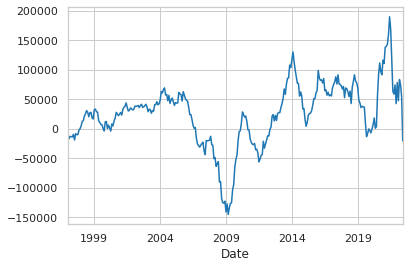

In [5]:
# SCRUB - OUR TIME SERIES IS NOT STATIONARY - WE NEED TO TAKE THE DIFFERENCE
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

#X = O['Price']
X = C['Price']
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = C.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# plot
stationary.plot()

In [6]:
# SCRUB - SOME CODE TO INVERT DIFFERENCE VALUE

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

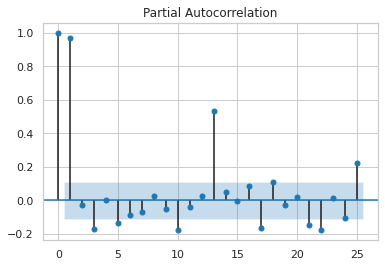

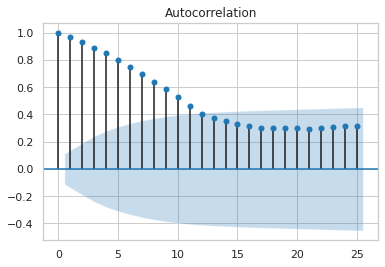

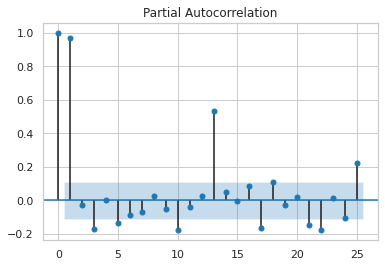

In [7]:
# USING STATIONARY TIME SERIES LOOK AT ACF

series = stationary

plot_acf(series)
plot_pacf(series)

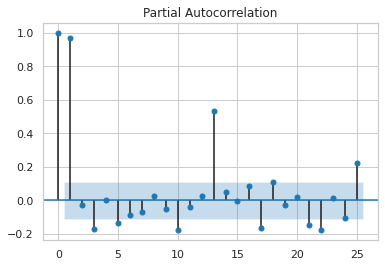

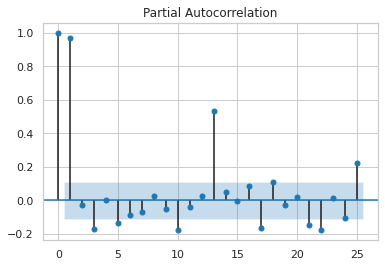

In [8]:
# USING STATIONARY TIME SERIES LOOK FOR PACF

plot_pacf(series)

In [9]:
# BUILD THE MODEL - USING ORIGINAL SERIES1 DATA

# prepare data
#X = O['Price']
X = C['Price']
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=220870.648, Expected=227845
>Predicted=215459.643, Expected=227163
>Predicted=228298.377, Expected=228676
>Predicted=210653.999, Expected=231567
>Predicted=224876.657, Expected=235878
>Predicted=214998.428, Expected=241068
>Predicted=226955.270, Expected=239658
>Predicted=239727.124, Expected=240535
>Predicted=231304.068, Expected=252613
>Predicted=232743.200, Expected=246614
>Predicted=250118.903, Expected=244140
>Predicted=234450.464, Expected=243796
>Predicted=238126.378, Expected=256304
>Predicted=259889.430, Expected=250725
>Predicted=257011.867, Expected=248378
>Predicted=249947.225, Expected=253070
>Predicted=256465.191, Expected=248154
>Predicted=253580.332, Expected=239088
>Predicted=234906.568, Expected=237389
>Predicted=234731.186, Expected=223410
>Predicted=234960.750, Expected=229659
>Predicted=219604.267, Expected=220519
>Predicted=216429.658, Expected=217064
>Predicted=215875.675, Expected=218901
>Predicted=231234.080, Expected=220800
>Predicted=215424.893, Ex

                  0
count    159.000000
mean     492.839511
std    16317.547394
min   -72230.383092
25%    -7145.385013
50%      915.216915
75%     9705.819161
max    57690.231142
RMSE: 16273.618


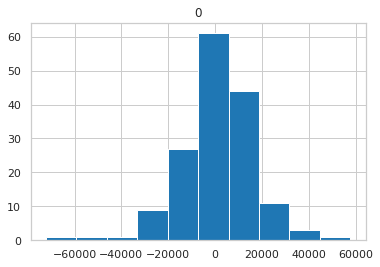

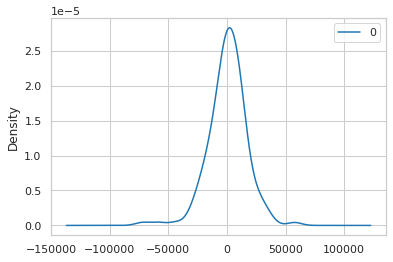

In [10]:
#Zip97212 ARIMA()
#@title
# SIMILAR BLOCK OF CODE - THIS ONE SAVES RESIDUALS FOR PLOTTING

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = C['Price']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# plot
residuals.hist(ax=plt.gca())
plt.show()

residuals.plot(kind='kde', ax=plt.gca())
plt.show()

                  0
count    159.000000
mean     613.552598
std    16317.547394
min   -72109.670005
25%    -7024.671926
50%     1035.930002
75%     9826.532248
max    57810.944229
RMSE: 16277.721


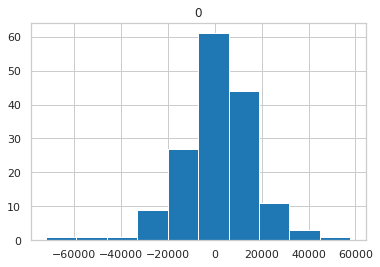

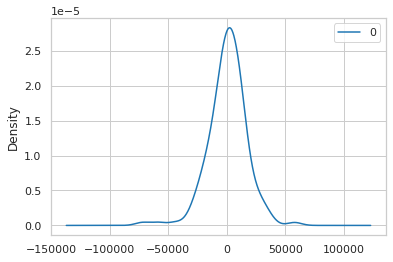

In [11]:
# MODEL - INTERPRET 
# RECREATE ANALYSIS WITH MEAN RESIDUAL ADDED TO EACH PREDICTION
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = C['Price']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = -120.713087
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# plot
residuals.hist(ax=plt.gca())
plt.show()

residuals.plot(kind='kde', ax=plt.gca())
plt.show()

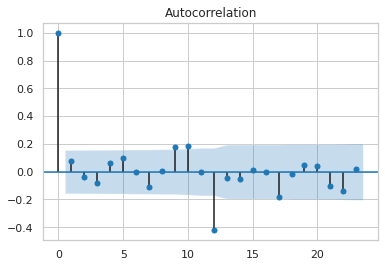

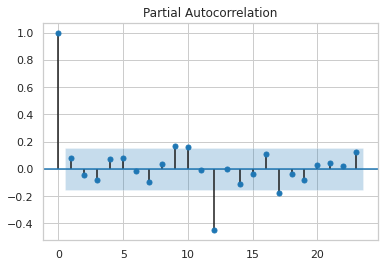

In [12]:
# INTERPRET -LOOK AT ACF AND PACF FOR RESIDUALS
# Ideally all residuals are not significant and mean==0
plot_acf(residuals, ax=plt.gca())
plt.show()

plot_pacf(residuals, ax=plt.gca())
plt.show()

In [13]:
# MODEL - CODE FROM BROWNLEE FOR SAVING MODEL
# NOTE:  This will save in your google drive UNLESS you specified a particular
# working directory

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# prepare data
X = C['Price']
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(2,1,0))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual - CHANGED TO ZERO
bias = 0
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

In [14]:
# MODEL
# CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING ONE STEP AHEAD

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = C['Price']
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 815214.150


In [15]:
# INTERPRET - CREATE TRAIN-TEST DATA
# DATA IS WEEKLY FOR 2+ years
# KEEP ONE QUARTER - 13 weeks - AS THE TEST DATA

series1 = pd.read_csv('C.csv', header=0,
                      index_col="Date", parse_dates=["Date"])
split_point = len(series) - 24
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

# STORES TO LOCAL DRIVE
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 294, Validation 24


>Predicted=815214.140, Expected=676141
>Predicted=608818.511, Expected=703708
>Predicted=668894.620, Expected=715445
>Predicted=724310.210, Expected=722510
>Predicted=729513.770, Expected=713792
>Predicted=711250.054, Expected=744469
>Predicted=773363.477, Expected=733982
>Predicted=736030.576, Expected=770540
>Predicted=820575.243, Expected=782158
>Predicted=783788.643, Expected=795309
>Predicted=777796.044, Expected=797543
>Predicted=762674.285, Expected=835856
>Predicted=703059.205, Expected=844680
>Predicted=901658.005, Expected=818241
>Predicted=825120.850, Expected=778620
>Predicted=779955.493, Expected=781254
>Predicted=772045.004, Expected=787726
>Predicted=820079.243, Expected=786996
>Predicted=773173.020, Expected=812339
>Predicted=852334.910, Expected=817896
>Predicted=826855.161, Expected=865358
>Predicted=881232.270, Expected=869454
>Predicted=871031.190, Expected=851362
>Predicted=888171.126, Expected=815151
RMSE: 58644.974


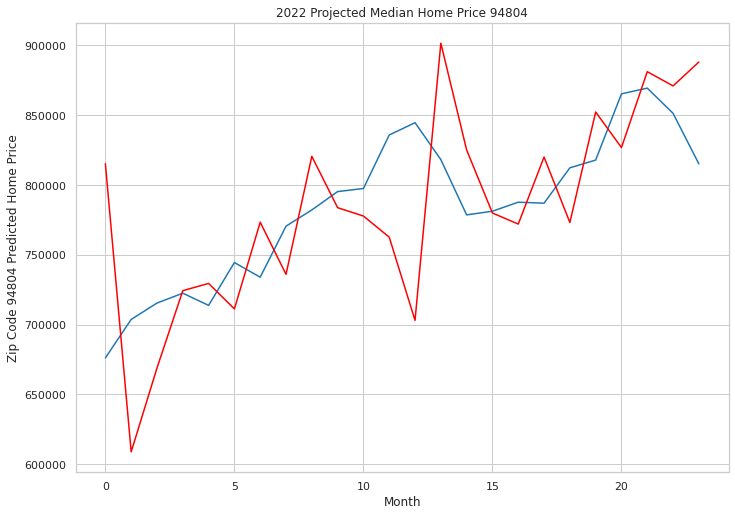

In [16]:
# MODEL & INTERPRET - 
# CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING MANY STEPS AHEAD
# NEED VALIDATION FILE FROM ABOVE


def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load and prepare datasets
dataset = C['Price']
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
#validation = Series.from_csv('validation.csv', header=0)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	Months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
fig, ax = plt.subplots(figsize = dims)
plt.plot(y)
plt.plot(predictions, color='red')
plt.xlabel("Month")
plt.ylabel("Zip Code 94804 Predicted Home Price")
plt.title("2022 Projected Median Home Price 94804")
plt.show()

In [17]:
# timeseries data
ts_start = Zip94804.columns.get_loc('1996-01-31') + 1
ts_end = Zip94804.columns.get_loc('2022-06-30')
date_columns = Zip94804.iloc[:, ts_start:ts_end].columns.tolist()

# ensure integer timeseries
Zip94804[date_columns] = Zip94804[date_columns].astype(int)

In [18]:
# train: collapse column by median
train_start = Zip94804.columns.get_loc('1996-01-31')
train_stop = Zip94804.columns.get_loc('2021-12-31')
test_stop = Zip94804.columns.get_loc('2022-06-30')
train_columns = Zip94804.iloc[:, train_start:train_stop].columns.tolist()
test_columns = Zip94804.iloc[:, (train_stop + 1):test_stop].columns.tolist()


In [19]:
# remove rows with 0's beginning (1997-01) with trainset
date_columns = Zip94804.iloc[:, train_start:test_stop].columns.tolist()

Zip94804[date_columns] = Zip94804[date_columns].replace(0, np.nan)
Zip94804[date_columns] = Zip94804[date_columns].dropna()

In [20]:
# Creating training and testing datasets
df_train = Zip94804[train_columns].median().T
df_test = Zip94804[test_columns].median().T

In [21]:
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 10

for t in range(iterations):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 12:
        year = 2022
        month = (t+ 2) % 12
        if month == 0:
            month = 12
    else:
        year = 2022
        month = t+ 2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    #
    # observation: if current value doesn't exist from test, append current
    #     predition, to ensure successive rolling prediction computed.
    #
    try:
        obs = df_test[t]
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        obs = yhat
        print('predicted={:03f}'.format(float(yhat)))

    history.append(obs)


date: 2022-2
-----------------------------------------------
predicted=790400.960231, expected=812339.000000
prediction difference: 0.027006

predicted=790400.960231

date: 2022-3
-----------------------------------------------
predicted=792467.728948, expected=817895.000000
prediction difference: 0.031089

predicted=792467.728948


/usr/local/lib/python3.7/dist-packages/statsmodels/base/data.py:629: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  endog = np.asarray(endog)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:424: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _endog = endog if hasattr(endog, 'ndim') else np.asarray(endog)



date: 2022-4
-----------------------------------------------
predicted=794436.732439, expected=865358.000000
prediction difference: 0.081956

predicted=794436.732439

date: 2022-5
-----------------------------------------------
predicted=796409.033415, expected=869453.000000
prediction difference: 0.084011

predicted=796409.033415

date: 2022-6
-----------------------------------------------
predicted=798362.936596, expected=851362.000000
prediction difference: 0.062252

Test MSE: 2860394334.147131



date: 2022-7
-----------------------------------------------
predicted=861982.166978


/usr/local/lib/python3.7/dist-packages/statsmodels/base/data.py:629: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  endog = np.asarray(endog)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:424: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _endog = endog if hasattr(endog, 'ndim') else np.asarray(endog)



date: 2022-8
-----------------------------------------------
predicted=865516.144441

date: 2022-9
-----------------------------------------------
predicted=867888.776047

date: 2022-10
-----------------------------------------------
predicted=870092.408569

date: 2022-11
-----------------------------------------------
predicted=872264.022077

date: 2022-12
-----------------------------------------------
predicted=874434.996709

date: 2022-13
-----------------------------------------------
predicted=876589.137727

date: 2022-14
-----------------------------------------------
predicted=878740.578314

date: 2022-3
-----------------------------------------------
predicted=880891.585685

date: 2022-4
-----------------------------------------------
predicted=883060.075011

date: 2022-5
-----------------------------------------------
predicted=885213.871531

date: 2022-6
-----------------------------------------------
predicted=887365.310856


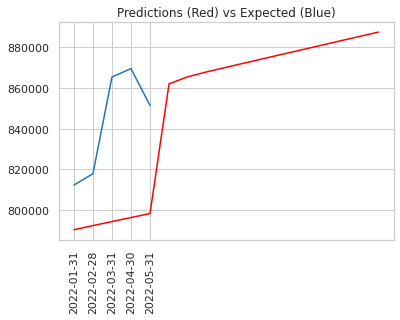

In [22]:
# plot rolling prediction
def rolling_plot(data, predictions):
    plt.plot(predictions, color='red')
    plt.plot(df_test)
    plt.xticks(rotation=90)
    plt.title('Predictions (Red) vs Expected (Blue)')
    plt.show()
    ax.set_xlim([25, 50])
rolling_plot(y, predictions)